In [1]:
import src.util as util
import numpy as np
import pandas as pd
import copy
import hashlib
import json

from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, ridge_regression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

from sklearn.model_selection import KFold, cross_val_score

In [2]:
config_data = util.load_config()

## LOAD DATASET
-----

In [3]:
def load_train_clean(config_data: pd.DataFrame) -> pd.DataFrame:
        X = util.pickle_load(config_data["train_set_clean"][0])
        y = util.pickle_load(config_data["train_set_clean"][1])

        return X, y
    
def load_valid_clean(config_data: pd.DataFrame) -> pd.DataFrame:
        X = util.pickle_load(config_data["valid_set_clean"][0])
        y = util.pickle_load(config_data["valid_set_clean"][1])

        return X, y

def load_test_clean(config_data: pd.DataFrame) -> pd.DataFrame:
        X = util.pickle_load(config_data["test_set_clean"][0])
        y = util.pickle_load(config_data["test_set_clean"][1])

        return X, y

In [4]:
X_train, y_train = load_train_clean(config_data)
X_valid, y_valid = load_valid_clean(config_data)
X_test, y_test = load_test_clean(config_data)

In [5]:
X_train['filter'].columns == X_valid['filter'].columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

## Baseline Model

Check does mean of model could be enough to predict data.

**Reference:**
[Metrics](https://coderzcolumn.com/tutorials/machine-learning/model-evaluation-scoring-metrics-scikit-learn-sklearn)

## Creating Training Log Template

In [6]:
util.print_debug('Create training log template')

2023-06-18 09:56:03.405479 Create training log template


In [7]:
## Create training log function
def training_log_template() -> dict:
    # Debug message
    util.print_debug("creating training log template")

    # Template for training Log
    logger = {
        "model_name": [],
        "model_uid": [],
        "training_time": [],
        "training_date": [],
        "rmse": [],
        "r2_score": [],
    }

    # Debug message
    util.print_debug("Training log template created")

    return logger

In [8]:
def training_log_updater(current_log: dict, params: dict) -> list:
    # create copy of current log
    current_log = copy.deepcopy(current_log)

    # Path for training log file
    log_path = params["training_log_path"]

    # Try to load training log file
    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()

    # If file not found create a new one
    except FileNotFoundError as fe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()

        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()

    # Add current log to previous log
    last_log.append(current_log)

    # Save updated log
    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    # Return log
    return last_log

In [9]:
## Create model object of ML model
def create_model_object(params: dict) -> list:
    # Debug message
    util.print_debug("Creating model objects.")

    # Create model objects
    baseline_knn = KNeighborsRegressor()
    baseline_dt = DecisionTreeRegressor()
    baseline_lr = LinearRegression()
    baseline_svr = SVR()
    baseline_rf = RandomForestRegressor()
    baseline_ada = AdaBoostRegressor()
    baseline_gr = GradientBoostingRegressor()
    baseline_xgb = XGBRegressor()

    # Create list of model
    list_of_model = [
        {"model_name": baseline_knn.__class__.__name__, "model_object": baseline_knn, "model_uid": ""},
        {"model_name": baseline_dt.__class__.__name__, "model_object": baseline_dt, "model_uid": ""},
        {"model_name": baseline_lr.__class__.__name__, "model_object": baseline_lr, "model_uid": ""},
        {"model_name": baseline_svr.__class__.__name__, "model_object": baseline_svr, "model_uid": ""},
        {"model_name": baseline_rf.__class__.__name__, "model_object": baseline_rf, "model_uid": ""},
        {"model_name": baseline_ada.__class__.__name__, "model_object": baseline_ada, "model_uid": ""},
        {"model_name": baseline_gr.__class__.__name__, "model_object": baseline_gr, "model_uid": ""},
        {"model_name": baseline_xgb.__class__.__name__, "model_object": baseline_xgb, "model_uid": ""},
    ]

    # Debug message
    util.print_debug("Models object created")

    return list_of_model
    

## **Modelling Baseline**

    Type I : List of model per config

In [ ]:
def train_eval(configuration_model: str, params: dict, hyperparams_model: list = None, data: str = 'filter'):

    # Variable to store trained models
    list_of_trained_model = dict()

    # Create training log template
    training_log = training_log_template()

    # Training for every data configuration
    util.print_debug("Training model based on current dataset")

    if hyperparams_model == None:
        list_of_model = create_model_object(params)
    else:
        list_of_model = copy.deepcopy(hyperparams_model)

    # Variable to store trained model
    trained_model = list()

    # Train each model by current dataset
    for model in list_of_model:
        # Debug message
        util.print_debug("Training model: {}".format(model["model_name"]))

        # Training
        training_time = util.time_stamp()
        model["model_object"].fit(X_train[data], y_train[data])
        training_time = (util.time_stamp() - training_time).total_seconds()

        # Debug message
        util.print_debug("Evaluating model: {}".format(model["model_name"]))

        # Evaluation
        y_predict = model["model_object"].predict(X_valid[data])
        rmse = mean_squared_error(y_valid[data], y_predict, squared=True)
        r2 = r2_score(y_valid[data], y_predict)

        # Debug message
        util.print_debug("Logging: {}".format(model["model_name"]))

        # Create UID
        uid = hashlib.md5(str(training_time).encode()).hexdigest()

        model["model_uid"] = uid

        # Create training log data
        training_log["model_name"].append("{}--{}".format(configuration_model, model["model_name"]))
        training_log["model_uid"].append(uid)
        training_log["training_time"].append(training_time)
        training_log["training_date"].append(util.time_stamp())
        training_log["rmse"].append(rmse)
        training_log["r2_score"].append(r2)

        # Collenct current trained model
        trained_model.append(copy.deepcopy(model))

        # Debug Message
        util.print_debug("Model {} has been trained".format(model["model_name"]))

    # Debug message
    util.print_debug("All combination models and data has been trained.")


    return trained_model, training_log

    Type II : List of Model All

In [10]:
def train_eval(configuration_model: str, params: dict, hyperparams_model: list = None):

    # Variable to store trained models
    list_of_trained_model = dict()

    # Create training log template
    training_log = training_log_template()

    for config in X_train:
        # Debug message
        util.print_debug("Training model based on configuration data: {}".format(config_data))

        if hyperparams_model == None:
            list_of_model = create_model_object(params)
        else:
            list_of_model = copy.deepcopy(hyperparams_model)

        # Variable to store trained model
        trained_model = list()

        X_train_data = X_train[config]
        y_train_data = y_train[config]
        X_valid_data = X_valid[config]
        y_valid_data = y_valid[config]

        # Train each model by current dataset
        for model in list_of_model:
            # Debug message
            util.print_debug("Training model: {}".format(model["model_name"]))

            # Training
            training_time = util.time_stamp()
            model["model_object"].fit(X_train_data, y_train_data)
            training_time = (util.time_stamp() - training_time).total_seconds()

            # Debug message
            util.print_debug("Evaluating model: {}".format(model["model_name"]))

            # Evaluation
            y_predict = model["model_object"].predict(X_valid_data)
            rmse = mean_squared_error(y_valid_data, y_predict, squared=True)
            r2 = r2_score(y_valid_data, y_predict)

            # Debug message
            util.print_debug("Logging: {}".format(model["model_name"]))

            # Create UID
            uid = hashlib.md5(str(training_time).encode()).hexdigest()

            model["model_uid"] = uid

            # Create training log data
            training_log["model_name"].append("{}-{}-{}".format(configuration_model, config, model["model_name"]))
            training_log["model_uid"].append(uid)
            training_log["training_time"].append(training_time)
            training_log["training_date"].append(util.time_stamp())
            training_log["rmse"].append(rmse)
            training_log["r2_score"].append(r2)

            # Collenct current trained model
            trained_model.append(copy.deepcopy(model))

            # Debug Message
            util.print_debug("Model {} has been trained".format(model["model_name"]))

        # Collect current trained list of model
        list_of_trained_model[config] = copy.deepcopy(trained_model)

    # Debug message
    util.print_debug("All combination models and data has been trained.")


    return list_of_trained_model, training_log

In [11]:
list_of_trained_model, training_log = train_eval("baseline", config_data)

2023-06-18 09:56:08.744482 creating training log template
2023-06-18 09:56:08.745480 Training log template created
2023-06-18 09:56:08.745480 Training model based on configuration data: {'raw_dataset_dir': 'data\\dataset\\', 'raw_dataset_path': 'data\\processed\\raw_dataset.pkl', 'cleaned_raw_dataset_path': 'data\\processed\\raw_dataset_clean.pkl', 'train_set_path': ['data/processed/X_train.pkl', 'data/processed/y_train.pkl'], 'valid_set_path': ['data/processed/X_valid.pkl', 'data/processed/y_valid.pkl'], 'test_set_path': ['data/processed/X_test.pkl', 'data/processed/y_test.pkl'], 'train_set_eda': ['data/processed/X_train_eda.pkl', 'data/processed/y_train_eda.pkl'], 'valid_set_eda': ['data/processed/X_valid_eda.pkl', 'data/processed/y_valid_eda.pkl'], 'test_set_eda': ['data/processed/X_test_eda.pkl', 'data/processed/y_test_eda.pkl'], 'train_set_clean': ['data/processed/X_train_clean.pkl', 'data/processed/y_train_clean.pkl'], 'valid_set_clean': ['data/processed/X_valid_clean.pkl', 'data

    Create Function to Save Production Model

In [61]:
def get_production_model(list_of_model, training_log, params):
    # Create copy list of model
    list_of_model = copy.deepcopy(list_of_model)
    
    # Debug message
    util.print_debug("Choosing model by metrics score.")

    # Create required predefined variabel
    curr_production_model = None
    prev_production_model = None
    production_model_log = None

    # Debug message
    util.print_debug("Converting training log type of data from dict to dataframe.")

    # Convert dictionary to pandas for easy operation
    training_log = pd.DataFrame(copy.deepcopy(training_log))

    # Debug message
    util.print_debug("Trying to load previous production model.")

    # Check if there is a previous production model
    try:
        prev_production_model = util.pickle_load(params["production_model_path"])
        util.print_debug("Previous production model loaded.")

    except FileNotFoundError as fe:
        util.print_debug("No previous production model detected, choosing best model only from current trained model.")

    # If previous production model detected:
    if prev_production_model != None:
        # Debug message
        util.print_debug("Loading validation data.")
        X_valid['filter'], y_valid['filter']
        
        # Debug message
        util.print_debug("Checking compatibilty previous production model's input with current train data's features.")

        # Check list features of previous production model and current dataset
        production_model_features = set(prev_production_model["model_data"]["model_object"].feature_names_in_)
        current_dataset_features = set(X_valid['filter'].columns)
        number_of_different_features = len((production_model_features - current_dataset_features) | (current_dataset_features - production_model_features))

        # If feature matched:
        if number_of_different_features == 0:
            # Debug message
            util.print_debug("Features compatible.")

            # Debug message
            util.print_debug("Reassesing previous model performance using current validation data.")

            # Re-predict previous production model to provide valid metrics compared to other current models
            y_pred = prev_production_model["model_data"]["model_object"].predict(X_valid['filter'])

            # Re-asses prediction result
            eval_res = mean_squared_error(y_valid['filter'], y_pred, squared = True)
            eval_r2 = r2_score(y_valid['filter'], y_pred)

            # Debug message
            util.print_debug("Assessing complete.")

            # Debug message
            util.print_debug("Storing new metrics data to previous model structure.")

            # Update their performance log
            prev_production_model["model_log"]["rmse"] = eval_res
            prev_production_model["model_log"]["r2_score"] = eval_r2

            # Debug message
            util.print_debug("Adding previous model data to current training log and list of model")

            # Added previous production model log to current logs to compere who has the greatest f1 score
            training_log = pd.concat([training_log, pd.DataFrame([prev_production_model["model_log"]])])

            # Added previous production model to current list of models to choose from if it has the greatest f1 score
            list_of_model["prev_production_model"] = [copy.deepcopy(prev_production_model["model_data"])]
        else:
            # To indicate that we are not using previous production model
            prev_production_model = None

            # Debug message
            util.print_debug("Different features between production model with current dataset is detected, ignoring production dataset.")

    # Debug message
    util.print_debug("Sorting training log by f1 macro avg and training time.")

    # Sort training log by f1 score macro avg and trining time
    best_model_log = training_log.sort_values(["rmse", "training_time"], ascending = [True, True]).iloc[0]
    
    # Debug message
    util.print_debug("Searching model data based on sorted training log.")

    # Get model object with greatest f1 score macro avg by using UID
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_log["model_uid"]:
                curr_production_model = dict()
                curr_production_model["model_data"] = copy.deepcopy(model_data)
                curr_production_model["model_log"] = copy.deepcopy(best_model_log.to_dict())
                curr_production_model["model_log"]["model_name"] = "Filter-{}".format(curr_production_model["model_data"]["model_name"])
                curr_production_model["model_log"]["training_date"] = str(curr_production_model["model_log"]["training_date"])
                production_model_log = training_log_updater(curr_production_model["model_log"], params)
                break
    
    # In case UID not found
    if curr_production_model == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    # Debug message
    util.print_debug("Model chosen.")

    # Dump chosen production model
    util.pickle_dump(curr_production_model, params["production_model_path"])
    
    # Return current chosen production model, log of production models and current training log
    return curr_production_model, production_model_log, training_log

In [62]:
model, production_model_log, training_logs = get_production_model(list_of_trained_model, training_log, config_data)

2023-06-18 12:29:25.369596 Choosing model by metrics score.
2023-06-18 12:29:25.370596 Converting training log type of data from dict to dataframe.
2023-06-18 12:29:25.375600 Trying to load previous production model.
2023-06-18 12:29:25.496595 Previous production model loaded.
2023-06-18 12:29:25.496595 Loading validation data.
2023-06-18 12:29:25.496595 Checking compatibilty previous production model's input with current train data's features.
2023-06-18 12:29:25.496595 Features compatible.
2023-06-18 12:29:25.496595 Reassesing previous model performance using current validation data.
2023-06-18 12:29:25.851852 Assessing complete.
2023-06-18 12:29:25.851852 Storing new metrics data to previous model structure.
2023-06-18 12:29:25.851852 Adding previous model data to current training log and list of model
2023-06-18 12:29:25.890592 Sorting training log by f1 macro avg and training time.
2023-06-18 12:29:25.892583 Searching model data based on sorted training log.
2023-06-18 12:29:26.04

### **Model Performance**

In [72]:
pd.set_option('display.max_colwidth', None)
# pd.reset_option('display.max_colwidth')
training_logs[["model_name", "rmse", "r2_score", "training_time"]].sort_values(["rmse", "r2_score","training_time"], 
                                                                               ascending=[True, True, True])\
                                                                                   .head(10)

,model_name,rmse,r2_score,training_time
4,baseline-filter-RandomForestRegressor,1.023248,0.998874,47.968763
0,Filter-RandomForestRegressor,1.023248,0.998874,47.968763
12,baseline-lasso-RandomForestRegressor,1.293594,0.998577,28.360851
7,baseline-filter-XGBRegressor,1.604971,0.998234,10.798292
9,baseline-lasso-DecisionTreeRegressor,1.713378,0.998115,0.452715
15,baseline-lasso-XGBRegressor,1.901474,0.997908,5.133614
1,baseline-filter-DecisionTreeRegressor,3.568395,0.996074,0.548196
14,baseline-lasso-GradientBoostingRegressor,385.831639,0.575457,10.942846
6,baseline-filter-GradientBoostingRegressor,408.120985,0.550931,25.368958
0,baseline-filter-KNeighborsRegressor,588.179408,0.352807,0.021531


    Based on baseline model show that Filter method on Random Forest Regression has the best model,
    however the model takes more time to predict, if training time would be considered the 
    Lasso Method on Decision Tree Regression or XGBoost Regressor could be considered

    Decision Tree Regression can lead to high variance model (overfit), we should calculate the model performance on test model later, but it more easily to interpret using Decision Tree,
    If you want to minimize error with short amount of time, XGBoost Regression is the best choice. But the model is more difficult to interpretate.

## **Cross Validation Score**

In [15]:
list_of_model = create_model_object(config_data)

2023-06-18 10:19:31.084261 Creating model objects.
2023-06-18 10:19:31.084261 Models object created


**Cross Validation score**

CVS is performed to understand the distribution of data that we can be sure out model generalises well accross the whole dataset and not just a single portion. <br>

    How do we now that single dataset is representative?

Cross Val Score train and test our model on **multiple folds** and give a better understanding of model performance over the whole dataset instead of just a single train/test split. <br>

If we see that the metrics for all folds cvs are significant differences between them then this may indicate over-fitting to certain folds. <br>

!! **Scoring**: <br>
*neg_mean_squared_error* always return negative (-), it because cross_val_score function will return maximize value as sign **higher is better**, the cross_val_score will turn it into negative (-), <br>
hence, cross_val_score will return the smaller value.

As example of, <br>
5 is better than 9. Cross val score will return the higher which is 9. As of that, cross_val_score function will turn it into -5 and -9, and cross_val_score will return -5 as the higher value. <br>

**Reference:**<br>
[cross_val_score](https://scikit-learn.org/stable/modules/model_evaluation.html)

In [16]:
model_object = []
model_name = []

for model in list_of_model:
    model_object.append(model["model_object"])
    model_name.append(model["model_name"])

cv = KFold(n_splits=5)

for index, model in enumerate(model_object):
    cvs = cross_val_score(estimator=model, X=X_train['filter'], 
                          y=y_train['filter'], 
                          cv=cv, 
                          scoring='neg_root_mean_squared_error')
    mean = np.round(cvs.mean(), 3)
    std = np.round(cvs.std(), 3)
    print(f"cross validation score for the model {model_name[index]} is {mean} +/- {std}.")



cross validation score for the model KNeighborsRegressor is -25.007 +/- 0.246.
cross validation score for the model DecisionTreeRegressor is -1.252 +/- 0.249.
cross validation score for the model LinearRegression is -29.54 +/- 0.18.
cross validation score for the model SVR is -28.735 +/- 0.213.
cross validation score for the model RandomForestRegressor is -1.032 +/- 0.145.
cross validation score for the model AdaBoostRegressor is -28.573 +/- 0.345.
cross validation score for the model GradientBoostingRegressor is -19.941 +/- 0.24.
cross validation score for the model XGBRegressor is -1.3 +/- 0.089.


    Cross Val Score show Decision Tree Regressor, Random Forest Regressor, and XGBoost Regressor indicates the dataset is generalised.

## **Perform Hyperparameter for Model**

### Create Param Distribution

In [17]:
def create_dist_params(model_name:str) -> dict:
    dist_params_dt = {
        "criterion" : ['squared_error', 'absolute_error'],
        "min_samples_split" : np.arange(3,10,1).tolist(),
        "min_samples_leaf" : np.arange(2,10,1).tolist(),
        "max_depth" : np.arange(1,500,50).tolist(),
        "random_state" : [42]
    }

    dist_params_rf = {
        "n_estimators" : np.arange(100,501,100).tolist(),
        "criterion" : ["squared_error", "absolute_error"],
        "max_depth" : np.arange(2,11,1).tolist(),
        "min_samples_split" : np.arange(1,10,1).tolist(),
        "random_state" : [42]
    }

    dist_params_xgb = {
        "eta" : np.arange(0.1,1,0.1).tolist(),
        "max_depth" : np.arange(1,11,1).tolist(),
        "alpha" : np.arange(1,10,1).tolist(),
        "random_state" : [42]
    }

    dist_params = {
        "DecisionTreeRegressor" : dist_params_dt,
        "RandomForestRegressor" : dist_params_rf,
        "XGBRegressor" : dist_params_xgb
    }

    return dist_params[model_name]

### Create Hyper Param Function into one dict

In [18]:
def hyper_params_tuning(model: list) -> list:
    # Create copy of current best baseline model
    model_list = []
    trained_model = [DecisionTreeRegressor(),
                     RandomForestRegressor(),
                     XGBRegressor()]
    
    for col, mod in list(zip(model, trained_model)):
        dist_params = create_dist_params(col)
        model_rsc = RandomizedSearchCV(
            estimator = mod,
            param_distributions = dist_params,
            cv = cv,
            scoring = 'neg_root_mean_squared_error',
            n_jobs=-1
        )
        
        model = {
            "model_name" : col,
            "model_object" : model_rsc,
            "model_uid" : ""
        }

        model_list.append(model.copy())

    return model_list

    Run function to return list of GridSearchCv

In [19]:
list_model_ = hyper_params_tuning(['DecisionTreeRegressor',
                                   'RandomForestRegressor',
                                   'XGBRegressor'])

list_model_

[{'model_name': 'DecisionTreeRegressor',
  'model_object': RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                     estimator=DecisionTreeRegressor(), n_jobs=-1,
                     param_distributions={'criterion': ['squared_error',
                                                        'absolute_error'],
                                          'max_depth': [1, 51, 101, 151, 201, 251,
                                                        301, 351, 401, 451],
                                          'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                               8, 9],
                                          'min_samples_split': [3, 4, 5, 6, 7, 8,
                                                                9],
                                          'random_state': [42]},
                     scoring='neg_root_mean_squared_error'),
  'model_uid': ''},
 {'model_name': 'RandomForestRegressor',
  '

    Copy list of trained model

In [20]:
list__model = copy.deepcopy(list_of_trained_model)

    Update list of trained model with hyperparams model

In [21]:
for config in list__model:
    for l in (list_model_[0], list_model_[1], list_model_[2]):
        list__model[config].append(l)

In [22]:
for model in list__model['filter']:
    print(model['model_name'])

KNeighborsRegressor
DecisionTreeRegressor
LinearRegression
SVR
RandomForestRegressor
AdaBoostRegressor
GradientBoostingRegressor
XGBRegressor
DecisionTreeRegressor
RandomForestRegressor
XGBRegressor


In [23]:
list__model['filter'][-3:]

[{'model_name': 'DecisionTreeRegressor',
  'model_object': RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                     estimator=DecisionTreeRegressor(), n_jobs=-1,
                     param_distributions={'criterion': ['squared_error',
                                                        'absolute_error'],
                                          'max_depth': [1, 51, 101, 151, 201, 251,
                                                        301, 351, 401, 451],
                                          'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                               8, 9],
                                          'min_samples_split': [3, 4, 5, 6, 7, 8,
                                                                9],
                                          'random_state': [42]},
                     scoring='neg_root_mean_squared_error'),
  'model_uid': ''},
 {'model_name': 'RandomForestRegressor',
  '

    Run hyperparam model

In [49]:
def train_eval_hyper(configuration_model: str, params: dict, hyperparams_model: list = None, log_path: str = None):

    # Variable to store trained models
    list_of_trained_model = dict()

    # Create training log template
    training_log = training_log_template()

    for config in X_train:
        # Debug message
        util.print_debug("Training model based on configuration data: {}".format(config))

        if hyperparams_model == None:
            list_of_model = create_model_object(params)
        else:
            ## list of hyperparams is three models behind (look list__model[config])
            list_of_model = copy.deepcopy(hyperparams_model[config][-3:])

        # Variable to store trained model
        trained_model = list()

        X_train_data = X_train[config]
        y_train_data = y_train[config]
        X_valid_data = X_valid[config]
        y_valid_data = y_valid[config]

        # Train each model by current dataset
        for model in list_of_model:
            # Debug message
            util.print_debug("Training model: {}".format(model["model_name"]))

            # Training
            training_time = util.time_stamp()
            model["model_object"].fit(X_train_data, y_train_data)
            training_time = (util.time_stamp() - training_time).total_seconds()

            # Debug message
            util.print_debug("Evaluating model: {}".format(model["model_name"]))

            # Evaluation
            y_predict = model["model_object"].predict(X_valid_data)
            rmse = mean_squared_error(y_valid_data, y_predict, squared=True)
            r2 = r2_score(y_valid_data, y_predict)

            # Debug message
            util.print_debug("Logging: {}".format(model["model_name"]))

            # Create UID
            uid = hashlib.md5(str(training_time).encode()).hexdigest()

            model["model_uid"] = uid

            # Create training log data
            training_log["model_name"].append("{}-{}-{}".format(configuration_model, config, model["model_name"]))
            training_log["model_uid"].append(uid)
            training_log["training_time"].append(training_time)
            training_log["training_date"].append(util.time_stamp())
            training_log["rmse"].append(rmse)
            training_log["r2_score"].append(r2)

            # Collenct current trained model
            trained_model.append(copy.deepcopy(model))

            # Debug Message
            util.print_debug("Model {} has been trained".format(model["model_name"]))

        # Collect current trained list of model
        list_of_trained_model[config] = copy.deepcopy(trained_model)

    # Debug message
    util.print_debug("All combination models and data has been trained.")

    if log_path == None:
        training_log_ = training_log
    else:
        training_log_ = training_log_updater(training_log, log_path)

    return list_of_trained_model, training_log_

In [50]:
list_of_hyperparam_model, training_log_ = train_eval_hyper("hyperparam", 
                                                           config_data, 
                                                           list__model, 
                                                           config_data['training_log_path'])

2023-06-17 21:08:04.716413 creating training log template
2023-06-17 21:08:04.717408 Training log template created
2023-06-17 21:08:04.717408 Training model based on configuration data: filter
2023-06-17 21:08:04.719410 Training model: DecisionTreeRegressor


2023-06-17 21:40:03.049626 Evaluating model: DecisionTreeRegressor
2023-06-17 21:40:03.062190 Logging: DecisionTreeRegressor
2023-06-17 21:40:03.064159 Model DecisionTreeRegressor has been trained
2023-06-17 21:40:03.064159 Training model: RandomForestRegressor


## **Function to Test Dataset**

In [34]:
def train_eval(configuration_model: str, params: dict, hyperparams_model: list = None,
               X_t: pd.DataFrame = pd.DataFrame(), y_t: pd.DataFrame = pd.DataFrame()):

    # Variable to store trained models
    list_of_trained_model = dict()

    # Create training log template
    training_log = training_log_template()

    for config in X_train:
        # Debug message
        util.print_debug("Training model based on configuration data: {}".format(config))

        if hyperparams_model == None:
            list_of_model = create_model_object(params)
        else:
            list_of_model = copy.deepcopy(hyperparams_model)

        # Variable to store trained model
        trained_model = list()

        X_train_data = X_train[config]
        y_train_data = y_train[config]
        X_valid_data = X_t[config]
        y_valid_data = y_t[config]

        # Train each model by current dataset
        for model in list_of_model:
            # Debug message
            util.print_debug("Training model: {}".format(model["model_name"]))

            # Training
            training_time = util.time_stamp()
            model["model_object"].fit(X_train_data, y_train_data)
            training_time = (util.time_stamp() - training_time).total_seconds()

            # Debug message
            util.print_debug("Evaluating model: {}".format(model["model_name"]))

            # Evaluation
            y_predict = model["model_object"].predict(X_valid_data)
            rmse = mean_squared_error(y_valid_data, y_predict, squared=True)
            r2 = r2_score(y_valid_data, y_predict)

            # Debug message
            util.print_debug("Logging: {}".format(model["model_name"]))

            # Create UID
            uid = hashlib.md5(str(training_time).encode()).hexdigest()

            model["model_uid"] = uid

            # Create training log data
            training_log["model_name"].append("{}-{}-{}".format(configuration_model, config, model["model_name"]))
            training_log["model_uid"].append(uid)
            training_log["training_time"].append(training_time)
            training_log["training_date"].append(util.time_stamp())
            training_log["rmse"].append(rmse)
            training_log["r2_score"].append(r2)

            # Collenct current trained model
            trained_model.append(copy.deepcopy(model))

            # Debug Message
            util.print_debug("Model {} has been trained".format(model["model_name"]))

        # Collect current trained list of model
        list_of_trained_model[config] = copy.deepcopy(trained_model)

    # Debug message
    util.print_debug("All combination models and data has been trained.")


    return list_of_trained_model, training_log

In [35]:
list_of_test_model, testing_log = train_eval("baseline", config_data, 
                                             X_t=X_test, 
                                             y_t=y_test)

2023-06-18 11:39:45.273267 creating training log template
2023-06-18 11:39:45.273267 Training log template created
2023-06-18 11:39:45.274268 Training model based on configuration data: filter
2023-06-18 11:39:45.274268 Creating model objects.
2023-06-18 11:39:45.274268 Models object created
2023-06-18 11:39:45.274268 Training model: KNeighborsRegressor
2023-06-18 11:39:45.293268 Evaluating model: KNeighborsRegressor
2023-06-18 11:39:49.039648 Logging: KNeighborsRegressor
2023-06-18 11:39:49.045653 Model KNeighborsRegressor has been trained
2023-06-18 11:39:49.045653 Training model: DecisionTreeRegressor
2023-06-18 11:39:49.605653 Evaluating model: DecisionTreeRegressor
2023-06-18 11:39:49.615593 Logging: DecisionTreeRegressor
2023-06-18 11:39:49.616586 Model DecisionTreeRegressor has been trained
2023-06-18 11:39:49.616586 Training model: LinearRegression
2023-06-18 11:39:49.695506 Evaluating model: LinearRegression
2023-06-18 11:39:49.699874 Logging: LinearRegression
2023-06-18 11:39

    Show Best Performance Model

In [71]:
pd.DataFrame(testing_log)[['model_name',
                           'training_time',
                           'rmse',
                           'r2_score']]\
.sort_values(['rmse', 'r2_score', 'training_time'],
             ascending=[True,True,True])\
.head(5)

,model_name,training_time,rmse,r2_score
12,baseline-lasso-RandomForestRegressor,28.253907,0.672545,0.999252
9,baseline-lasso-DecisionTreeRegressor,0.471996,0.774707,0.999139
4,baseline-filter-RandomForestRegressor,31.894251,0.928694,0.998968
15,baseline-lasso-XGBRegressor,5.471427,1.244590,0.998616
7,baseline-filter-XGBRegressor,6.303004,1.365370,0.998482


## Check Final Model

In [82]:
model['model_log']

{'model_name': 'Filter-RandomForestRegressor',
 'model_uid': '9ac12489b24189bd5442b97d8660689e',
 'training_time': 47.968763,
 'training_date': '2023-06-18 10:04:41.635079',
 'rmse': 1.0232480165986322,
 'r2_score': 0.9988740864368295}

**Best Model**<br>
    Best model performance based on validation data is Random Forest Regressor on Filter Data Configuration,<br>
    Show up with **RMSE Score = 1.023** and **R2_Score = 0.998** <br>
    However, it lag on **training time: 47.97s**

    If you prefer more fast training time with nearly score, you can choose:
**Random Forest Regressor on Lasso Data Configuration**<br>

----------

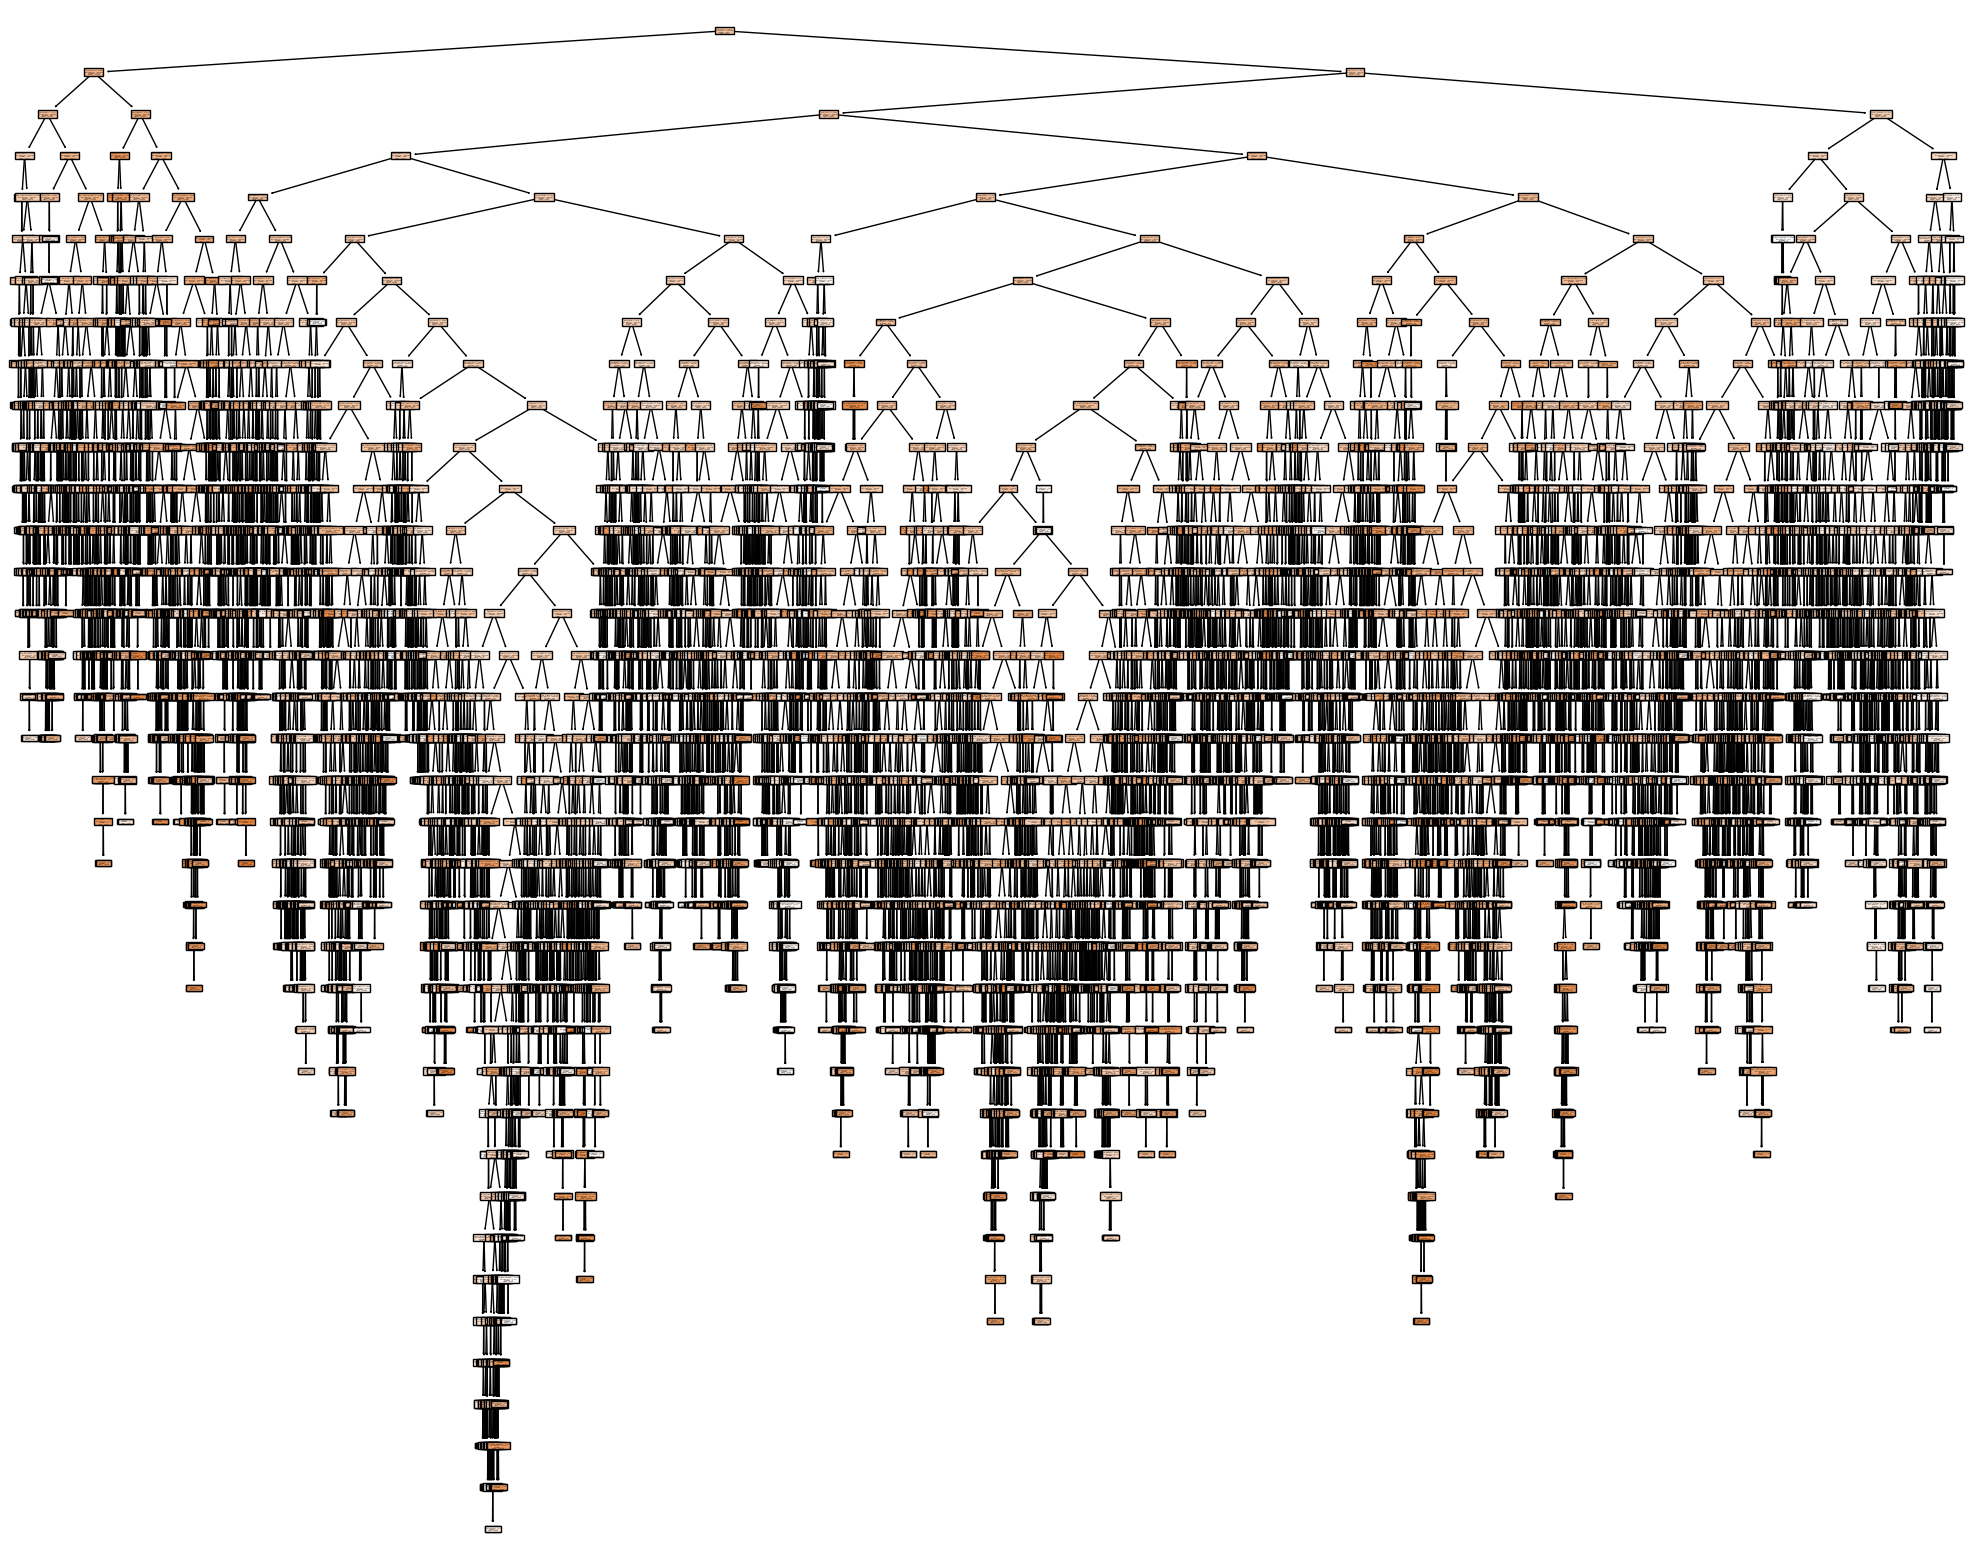

In [36]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtr, 
                   feature_names=X_valid.columns.to_list(),  
                   class_names='cost',
                   filled=True)